In [8]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor

Text(0, 0.5, 'y')

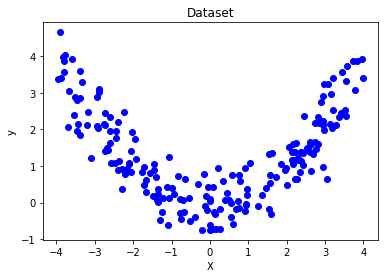

In [19]:
#generate nonlinear regression data
num_points = 200
x_min = -4
x_max = 4
c = 0.25
X = np.sort(np.random.uniform(x_min, x_max, num_points))

#statistics for noise
e_mean = 0
e_var = 0.5
e = np.random.normal(e_mean, e_var, num_points)

y = c * X ** 2 + e

plt.plot(X,y,'bo')
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('y')

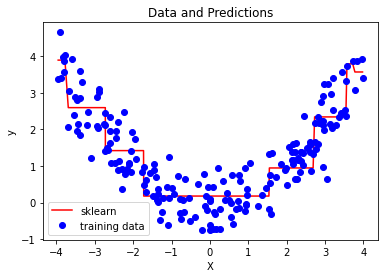

In [24]:
#GBRT sklearn
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X.reshape(-1,1),y)

y_pred = gbrt.predict(X.reshape(-1,1))
plt.plot(X,y_pred,'r',label='sklearn')
plt.plot(X,y,'bo',label='training data')
plt.title('Data and Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()